# Grupo 20: Thiago e Gabriele

In [30]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from sklearn import preprocessing

In [28]:
df = pd.read_csv('trabalho6_dados_20.csv')

## Análise inicial

In [29]:
df

,temperatura,vacuo,energia
0,23.82,44.89,445.45
1,22.72,69.84,436.70
2,12.11,41.17,475.53
3,30.27,64.05,438.68
4,15.23,37.87,464.02
...,...,...,...
11477,24.26,61.02,442.86
11478,21.67,69.71,440.16
11479,11.43,40.22,477.50
11480,27.60,69.05,436.08


In [5]:
df.describe()

,temperatura,vacuo,energia
count,11482.000000,11482.000000,11482.000000
mean,19.740275,54.433817,454.117745
std,7.437203,12.682335,17.079184
min,1.810000,25.360000,425.120000
25%,13.670000,41.780000,439.520000
50%,20.550000,52.720000,451.015000
75%,25.760000,66.540000,467.957500
max,37.110000,81.560000,495.760000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11482 entries, 0 to 11481
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   temperatura  11482 non-null  float64
 1   vacuo        11482 non-null  float64
 2   energia      11482 non-null  float64
dtypes: float64(3)
memory usage: 269.2 KB


## Visualização

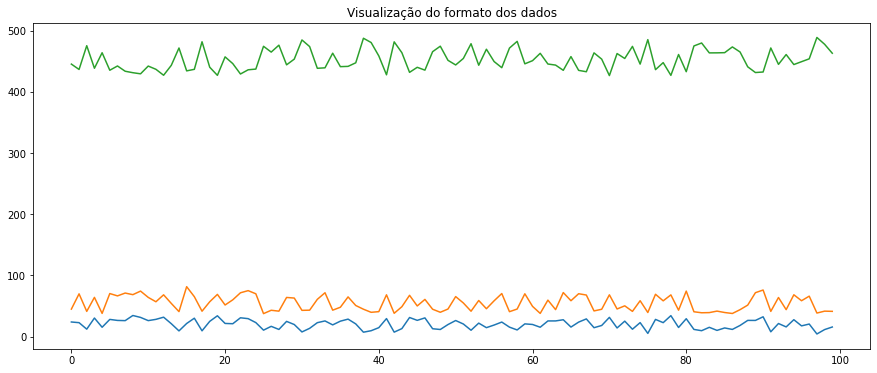

In [26]:
plt.figure(figsize=(15,6))
plt.plot(df.head(100)['temperatura'])
plt.plot(df.head(100)['vacuo'])
plt.plot(df.head(100)['energia'])
plt.title('Visualização do formato dos dados')
plt.show()

<AxesSubplot:>

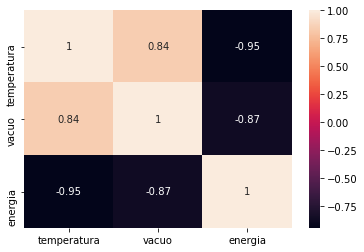

In [27]:
correlacao = df.corr()
sns.heatmap(correlacao, annot=True)

## Normalização

In [43]:
scaler = preprocessing.MinMaxScaler( feature_range=(0, 1) )
#x_norm = scaler.fit_transform(df)
df_norm = pd.DataFrame( scaler.fit_transform(df), columns=df.columns )
df_norm

,temperatura,vacuo,energia
0,0.623513,0.347509,0.287797
1,0.592351,0.791459,0.163930
2,0.291785,0.281317,0.713618
3,0.806232,0.688434,0.191959
4,0.380170,0.222598,0.550680
...,...,...,...
11477,0.635977,0.634520,0.251133
11478,0.562606,0.789146,0.212911
11479,0.272521,0.264413,0.741506
11480,0.730595,0.777402,0.155153


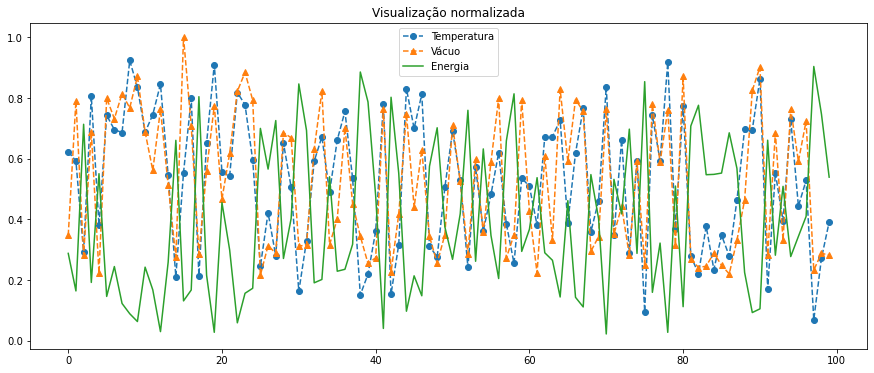

In [50]:
plt.figure(figsize=(15,6))
plt.plot(normalizados.head(100)['temperatura'], 'o--', label='Temperatura')
plt.plot(normalizados.head(100)['vacuo'], '^--',label='Vácuo')
plt.plot(normalizados.head(100)['energia'], label='Energia')
plt.title('Visualização normalizada')
plt.legend()
plt.show()